
=== 迭代 1/10 ===
模型R²: 0.96 (±0.02)

=== 迭代 2/10 ===
模型R²: 0.95 (±0.01)

=== 迭代 3/10 ===
模型R²: 0.96 (±0.01)

=== 迭代 4/10 ===
模型R²: 0.98 (±0.01)

=== 迭代 5/10 ===
模型R²: 0.95 (±0.04)

=== 迭代 6/10 ===
模型R²: 0.97 (±0.01)

=== 迭代 7/10 ===
模型R²: 0.97 (±0.01)

=== 迭代 8/10 ===
模型R²: 0.97 (±0.02)

=== 迭代 9/10 ===
模型R²: 0.97 (±0.01)

=== 迭代 10/10 ===
模型R²: 0.95 (±0.02)

=== 最终分析报告 ===
主要参数影响排序：
                 shap            perm_imp                coef
                 mean       std      mean       std      mean
term                                                         
weight_gsm  11.346877  0.921677  1.883158  0.095967 -0.300210
smoothness   0.759234  0.185347  0.016045  0.005678  3.142752
stiffness    0.152115  0.060588  0.001685  0.000559  0.648148

关键交互项影响排序：
                           shap            perm_imp                coef
                           mean       std      mean       std      mean
term                                                                   
smoothness we

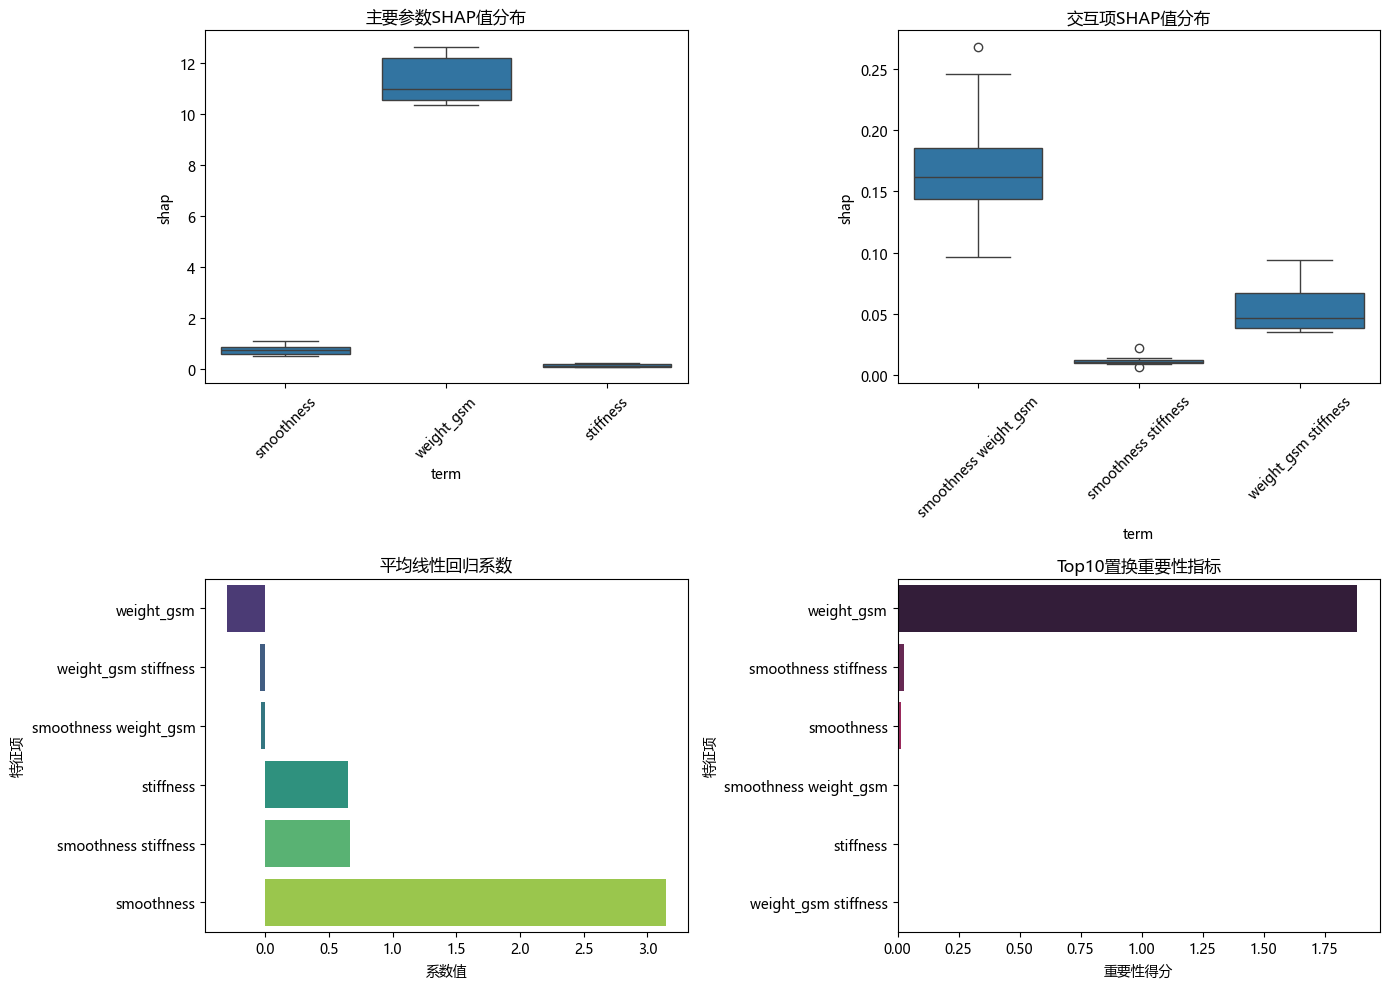

In [13]:
"""
纸飞机材料参数交互影响分析系统（最终修正版）
包含兼容性优化和警告修复
"""

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ========== 实验参数配置 ==========
PARAMS = {
    'smoothness': (1, 5),    # 光滑度范围
    'weight_gsm': (50, 200), # 克重范围(g/m²)
    'stiffness': (1, 5)      # 硬度范围
}

INTERACTION_LEVEL = 2        # 研究交互阶数（2阶）
SAMPLE_SIZE = 100            # 每次迭代样本量
ITERATIONS = 10              # 迭代次数
CV_FOLDS = 5                 # 交叉验证折数

# ========== 实验设计模块 ==========
class ExperimentDesign:
    def __init__(self, param_ranges):
        self.param_ranges = param_ranges
        self.params = list(param_ranges.keys())
        
    def latin_hypercube_sampling(self, n_samples):
        """拉丁超立方采样"""
        samples = {}
        for param, (low, high) in self.param_ranges.items():
            samples[param] = np.random.uniform(low, high, n_samples)
        return pd.DataFrame(samples)
    
    def generate_interaction_terms(self, df, degree=2):
        """生成交互项"""
        poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
        interactions = poly.fit_transform(df)
        terms = poly.get_feature_names_out(self.params)
        return pd.DataFrame(interactions, columns=terms).round(5)

# ========== 交互分析模块 ==========
class InteractionAnalyzer:
    @staticmethod
    def calculate_shap_interaction(model, X):
        """改进的SHAP交互值计算"""
        explainer = shap.TreeExplainer(model)
        shap_interaction_values = explainer.shap_interaction_values(X)
        
        # 计算各特征交互效应
        interaction_effects = {}
        n_features = X.shape[1]
        feature_names = X.columns.tolist()
        
        # 处理单特征影响
        for i in range(n_features):
            interaction_effects[feature_names[i]] = np.abs(shap_interaction_values[:,i,i]).mean()
        
        # 处理交互项影响（上三角矩阵）
        for i, j in combinations(range(n_features), 2):
            key = f"{feature_names[i]}×{feature_names[j]}"
            interaction_effects[key] = np.abs(shap_interaction_values[:,i,j]).mean()
            
        return interaction_effects

    @staticmethod
    def permutation_importance(model, X, y, n_repeats=10):
        """改进的置换重要性计算"""
        from sklearn.inspection import permutation_importance
        result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=42)
        return {col: result.importances_mean[i] for i, col in enumerate(X.columns)}

# ========== 主程序 ==========
def main():
    # 初始化实验设计
    exp_design = ExperimentDesign(PARAMS)
    interaction_records = []
    
    for iter in range(ITERATIONS):
        print(f"\n=== 迭代 {iter+1}/{ITERATIONS} ===")
        
        # 1. 生成实验样本
        samples = exp_design.latin_hypercube_sampling(SAMPLE_SIZE)
        
        # 2. 生成交互项
        X = exp_design.generate_interaction_terms(samples)
        
        # 3. 模拟实验结果（带噪声的预设物理关系）
        y = (
            0.5 * samples['smoothness'] * samples['stiffness'] 
            - 0.3 * samples['weight_gsm'] 
            + 0.2 * samples['smoothness']**2
            + np.random.normal(0, 0.1, SAMPLE_SIZE)
        )
        
        # 4. 训练模型
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(model, X, y, cv=CV_FOLDS)
        model.fit(X, y)
        print(f"模型R²: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")
        
        # 5. 交互分析
        shap_effects = InteractionAnalyzer.calculate_shap_interaction(model, X)
        perm_importance = InteractionAnalyzer.permutation_importance(model, X, y)
        
        # 6. 记录结果
        for term in X.columns:
            # 处理基础特征
            if term in PARAMS.keys():
                interaction_records.append({
                    'iteration': iter,
                    'term': term,
                    'type': 'main',
                    'shap': shap_effects.get(term, 0),
                    'perm_imp': perm_importance.get(term, 0),
                    'coef': _get_linear_coef(term, X, y)
                })
            # 处理交互项
            else:
                interaction_records.append({
                    'iteration': iter,
                    'term': term,
                    'type': 'interaction',
                    'shap': shap_effects.get(term.replace(' ', '×'), 0),
                    'perm_imp': perm_importance.get(term, 0),
                    'coef': _get_linear_coef(term, X, y)
                })
    
    # 结果分析与可视化
    results = pd.DataFrame(interaction_records)
    visualize_results(results)

def _get_linear_coef(term, X, y):
    """获取线性回归系数"""
    model = Lasso(alpha=0.01, max_iter=5000)
    model.fit(X[[term]], y)
    return model.coef_[0]

def visualize_results(results):
    """兼容性优化的可视化功能"""
    plt.figure(figsize=(14, 10))
    
    # SHAP值分布（箱线图）
    plt.subplot(2, 2, 1)
    sns.boxplot(x='term', y='shap', data=results[results['type'] == 'main'],
               order=list(PARAMS.keys()))
    plt.title('主要参数SHAP值分布')
    plt.xticks(rotation=45)
    
    # 交互项SHAP值分布
    plt.subplot(2, 2, 2)
    interaction_terms = results[results['type'] == 'interaction']['term'].unique()
    sns.boxplot(x='term', y='shap', data=results[results['type'] == 'interaction'],
               order=interaction_terms)
    plt.title('交互项SHAP值分布')
    plt.xticks(rotation=45)
    
    # 线性系数对比（修正部分）
    plt.subplot(2, 2, 3)
    coef_data = results.groupby('term')['coef'].mean().sort_values()
    sns.barplot(
        x=coef_data.values, 
        y=coef_data.index,
        hue=coef_data.index,  # 新增hue参数
        palette='viridis',
        legend=False,         # 禁用图例
        dodge=False           # 禁用自动偏移
    )
    plt.title('平均线性回归系数')
    plt.xlabel('系数值')
    plt.ylabel('特征项')
    
    # 重要性对比（修正部分）
    plt.subplot(2, 2, 4)
    importance_data = results.groupby('term')['perm_imp'].mean().sort_values(ascending=False)[:10]
    sns.barplot(
        x=importance_data.values, 
        y=importance_data.index,
        hue=importance_data.index,  # 新增hue参数
        palette='rocket',
        legend=False,               # 禁用图例
        dodge=False                 # 禁用自动偏移
    )
    plt.title('Top10置换重要性指标')
    plt.xlabel('重要性得分')
    plt.ylabel('特征项')
    
    plt.tight_layout()
    plt.savefig('interaction_analysis_report.png', dpi=300, bbox_inches='tight')
    
    # 控制台输出关键结果
    print("\n=== 最终分析报告 ===")
    print("主要参数影响排序：")
    main_effects = results[results['type'] == 'main'].groupby('term').agg({
        'shap': ['mean', 'std'],
        'perm_imp': ['mean', 'std'],
        'coef': 'mean'
    })
    print(main_effects.sort_values(('shap', 'mean'), ascending=False))
    
    print("\n关键交互项影响排序：")
    interaction_effects = results[results['type'] == 'interaction'].groupby('term').agg({
        'shap': ['mean', 'std'],
        'perm_imp': ['mean', 'std'],
        'coef': 'mean'
    })
    print(interaction_effects.sort_values(('shap', 'mean'), ascending=False).head(5))

if __name__ == "__main__":
    main()